In [2]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.5MB/s 


# **Introduction**

Big Mart is a chain of supermarkets with 58 stores currently operating in various parts of Kathmandu valley. It is one of the fastest growing express home delivery food and grocery retail store company covering worldwide. It has over 22,000 products and 1,200 brands. 

The data scientists at BigMart collected 2013 sales data for 1,559 products across 10 stores in different cities. The aim is to build a predictive model and predict the sales of each product at a particular outlet.


---


**Dataset description**

The aim is to determine the factors influencing sales in various stores. Different properties of both products and stores are provided as follows:


*   Outlet features

> Outlet Location Type

> Outlet Type

> Outlet Size

> Outlet Establishment Year

*   Item features


> Item weight

> Item fat content

> Item MRP(Max retail price)

> Item visibility

> Item Type



**Hypothesis**


*   All outlet features influence sales except establishment year
*   An item's weight is not strongly related to its sales
*   Item MRP is strongly correlated with sales value
*   Edible items make up for a larger share of Bigmart sales
*   Item fat content affects sales if the item is edible
*   Item visibility does not affect sales very much



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()
%load_ext google.colab.data_table

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Bigmart sales.csv'   catboost_info   drive   sample_data


In [3]:
Train = pd.read_csv('/content/drive/My Drive/Bigmart/Train.csv')
Test = pd.read_csv('/content/drive/My Drive/Bigmart/Test.csv')
display('training dataset', Train.head(), 'test data', Test.head())

'training dataset'

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


'test data'

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [4]:
Train['source']='Train'
Test['source']='Test'
data = pd.concat([Train, Test],ignore_index=True)
print (Train.shape, Test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


# **Exploratory Data Analysis**

In [5]:
data.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
count,14204,11765.000000,14204,14204.000000,14204,14204.000000,14204,14204.000000,10188,14204,14204,8523.000000,14204
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN,2
top,FDT19,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN,Train
freq,10,NaN,8485,NaN,2013,NaN,1559,NaN,4655,5583,9294,NaN,8523
mean,NaN,12.792854,NaN,0.065953,NaN,141.004977,NaN,1997.830681,NaN,NaN,NaN,2181.288914,NaN
std,NaN,4.652502,NaN,0.051459,NaN,62.086938,NaN,8.371664,NaN,NaN,NaN,1706.499616,NaN
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000,NaN
25%,NaN,8.710000,NaN,0.027036,NaN,94.012000,NaN,1987.000000,NaN,NaN,NaN,834.247400,NaN
50%,NaN,12.600000,NaN,0.054021,NaN,142.247000,NaN,1999.000000,NaN,NaN,NaN,1794.331000,NaN
75%,NaN,16.750000,NaN,0.094037,NaN,185.855600,NaN,2004.000000,NaN,NaN,NaN,3101.296400,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [7]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Train and test sets are combined to form one dataset and column source is created for distinction.
The dataset has 14,204 entires and 12 columns: 2 ID columns(Item and Outlet identifier), 5 item features, 4 outlet features and Item outlet sales, the target variable.

Item weight and Outlet size are the only columns with missing values. (Mising sales values are from test set, which is to be predicted by the model). In terms of datatypes, 5 features are categorical while 4 are numerical.

FDY39 is the most frequent item, appearing 10 times. Given that there are 10 outlets, this could mean that each item appears once per outlet. The most common outlet is OUT027, so it should have the most sales. Low fat items and fruits & vegetables are the most purchased items. Most outlets are supermrket type1, medium sized and located in Tier3 location types. There are items with zero visibility which should not be the case realistically. All this and more is presented in the visualizations below:

In [8]:
cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
data[cols].apply(lambda x: len(x.unique()))

Item_Weight                    416
Item_Visibility              13006
Item_MRP                      8052
Outlet_Establishment_Year        9
Item_Outlet_Sales             3494
dtype: int64

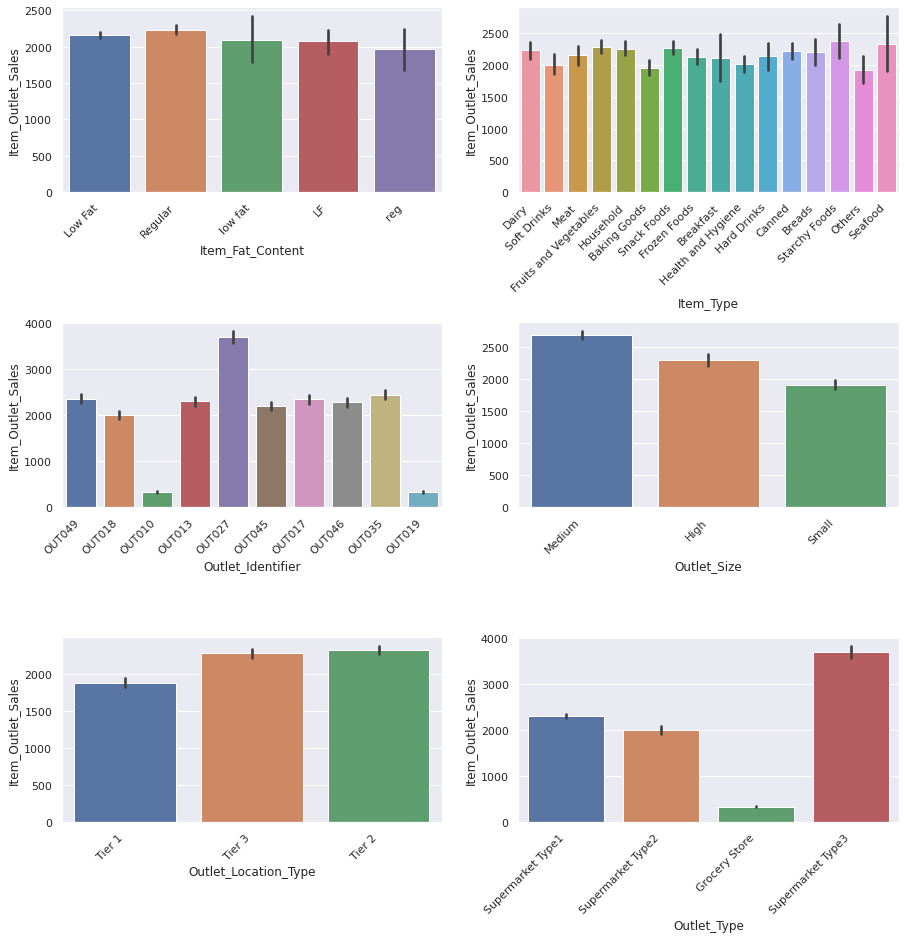

In [9]:
cols = data.iloc[:, [2,4,6,8,9,10]]

fig, axs = plt.subplots(nrows = 3, ncols=2, figsize=(15,15))
fig.subplots_adjust(hspace = .7, wspace=.2)
    
for ax, i in zip(axs.ravel(), cols.columns):
    sns.barplot(data=data, x = cols[i], y='Item_Outlet_Sales', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

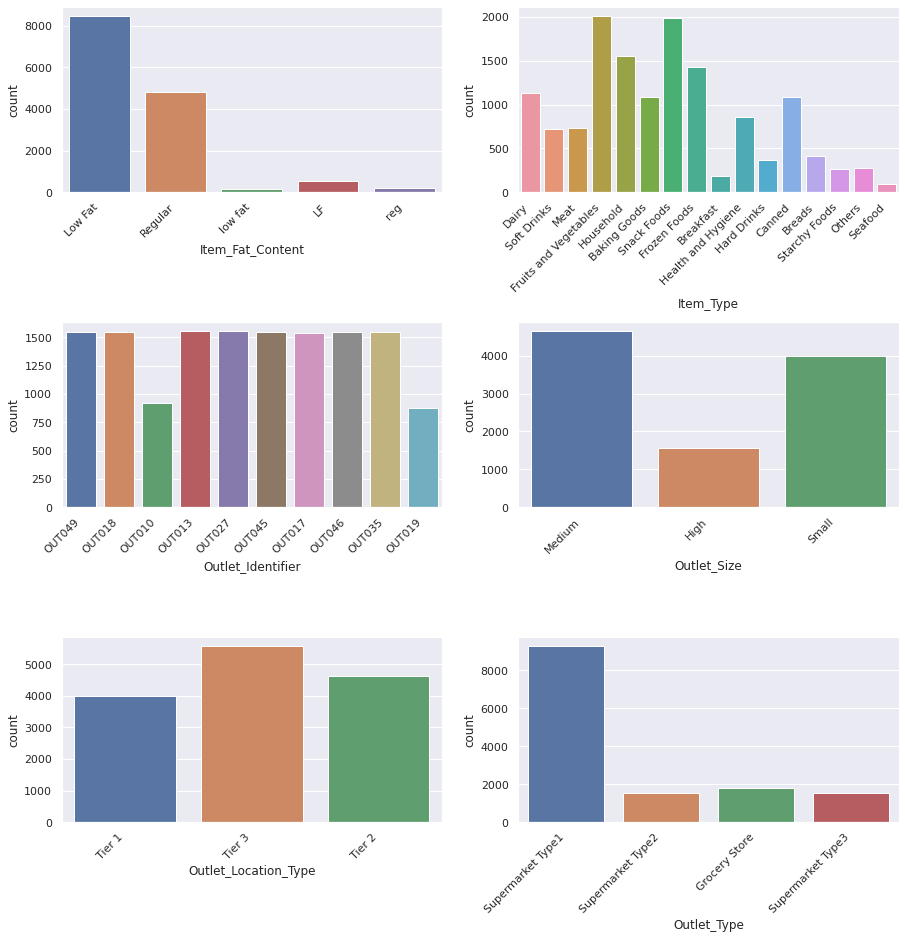

In [10]:
cols = data.iloc[:, [2,4,6,8,9,10]]

fig, axs = plt.subplots(nrows = 3, ncols=2, figsize=(15,15))
fig.subplots_adjust(hspace = .7, wspace=.2)
    
for ax, i in zip(axs.ravel(), cols.columns):
    sns.countplot(data=data, x = cols[i], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

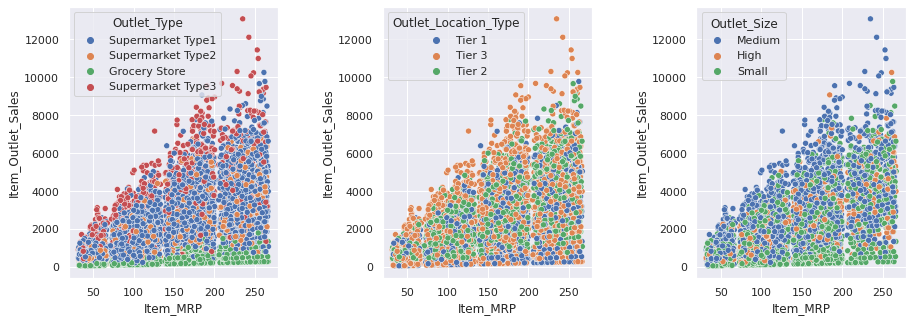

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
fig.subplots_adjust(hspace=.2, wspace=.5)
sns.scatterplot(data=data, x='Item_MRP', y='Item_Outlet_Sales', hue='Outlet_Type', ax=axs[0])
sns.scatterplot(data=data, x='Item_MRP', y='Item_Outlet_Sales', hue='Outlet_Location_Type', ax=axs[1])
sns.scatterplot(data=data, x='Item_MRP', y='Item_Outlet_Sales', hue='Outlet_Size', ax=axs[2])
plt.show()

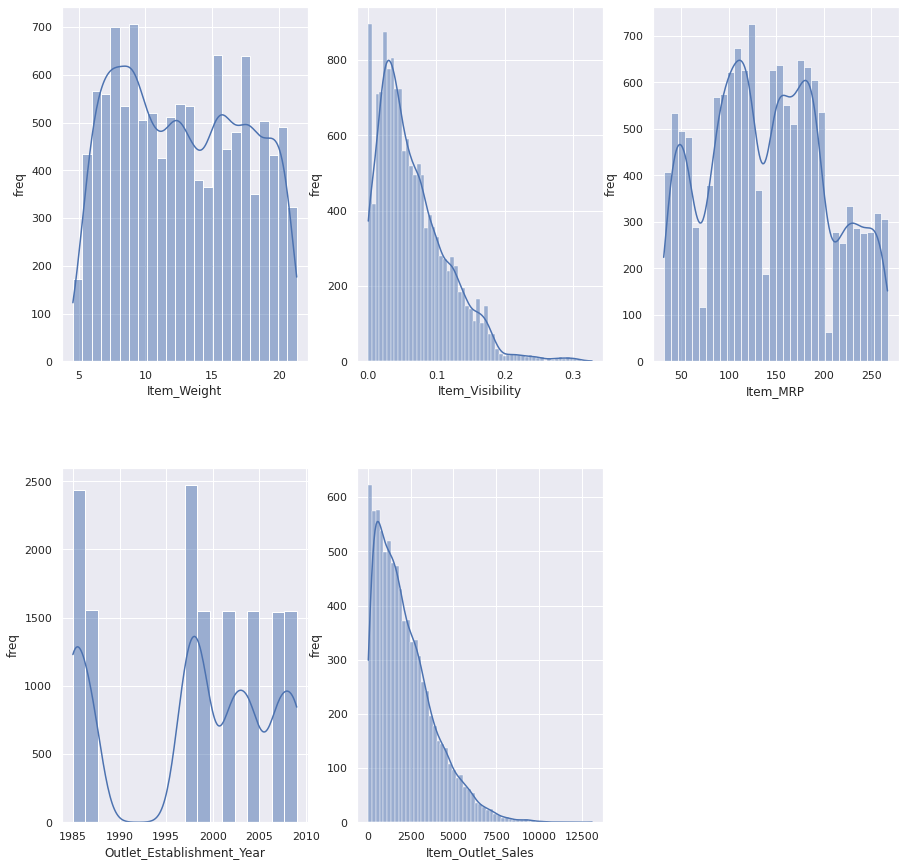

In [12]:
cols1 = data.iloc[:, [1,3,5,7,11]]

fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(15,15))
fig.subplots_adjust(hspace = .3, wspace=.2)
    
for ax, i in zip(axs.ravel(), cols1.columns):
    sns.histplot(data, x=data[i], ax=ax, kde=True)
    ax.set(xlabel=i, ylabel='freq')
axs[1,2].axis("off")
plt.show()

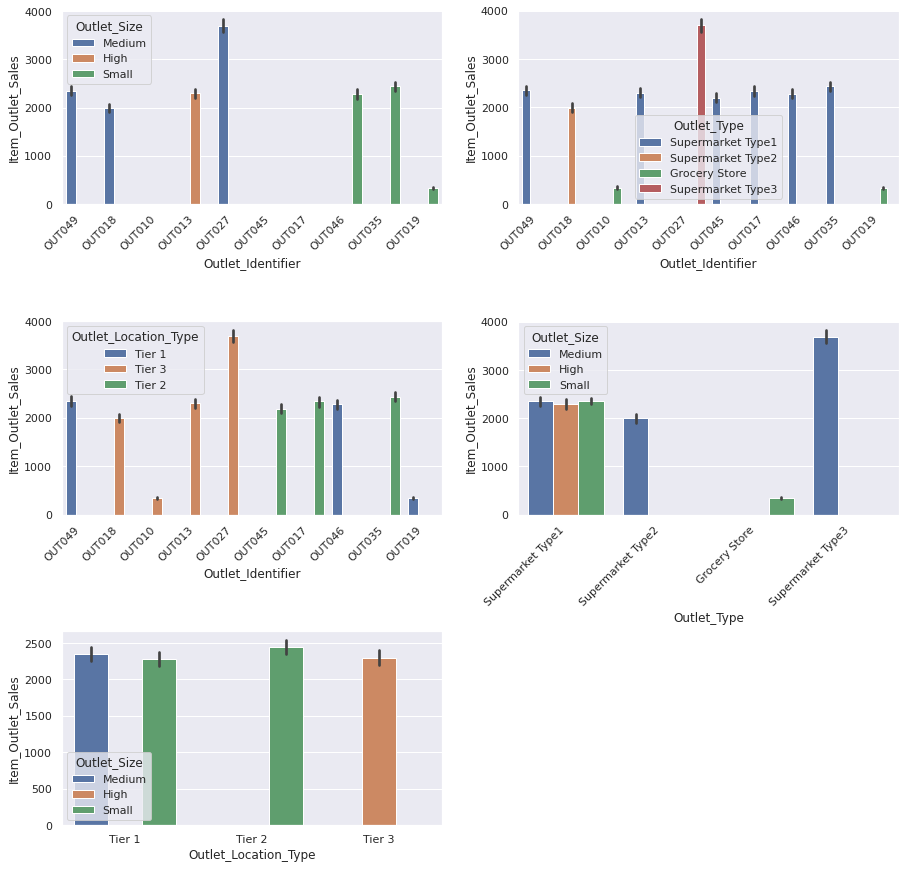

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.subplots_adjust(hspace = .6, wspace=.2)
sns.barplot(data=data, x='Outlet_Identifier', y='Item_Outlet_Sales', hue='Outlet_Size', ax=axs[0,0])
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45, horizontalalignment='right')
sns.barplot(data=data, x='Outlet_Identifier', y='Item_Outlet_Sales', hue='Outlet_Type', ax=axs[0,1])
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=45, horizontalalignment='right')
sns.barplot(data=data, x='Outlet_Identifier', y='Item_Outlet_Sales', hue='Outlet_Location_Type', ax=axs[1,0])
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45, horizontalalignment='right')
sns.barplot(data=data, x='Outlet_Type', y='Item_Outlet_Sales', hue='Outlet_Size', ax=axs[1,1])
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45, horizontalalignment='right')
sns.barplot(data=data[data['Outlet_Type']=='Supermarket Type1'], x='Outlet_Location_Type', y='Item_Outlet_Sales', hue='Outlet_Size', order=['Tier 1', 'Tier 2', 'Tier 3'], ax=axs[2,0])
axs[2,1].axis("off")
plt.show()

From the above plots, the following conclusions can be drawn:
1. Frequency of a feature doesn't necessarily translate to higher sales. eg. Sea food is the least frequent item yet it contributes more towards revenue. OUT027 is as frequent as 7 other outlets but outperforms all of them in sales.
2. Pricing seems to be separated into 4 distinct categories.
3. Bigmart mostly stocks small items since most items have very low visibility
4. From the data provided, it's not clear whether outlet age or establishment year has an impact on sales. OUT019 and OUT027 are the only ones established in the same year, but have different characteristics. OUT019 is a grocery store, small in size, in Tier 1 location while OUT027 is a medium sized supermarket type3 in Tier 3 location.


The following changes will be made during preprocessing:
1. 'low fat' and 'LF' will be replaced with 'Low Fat' while 'reg' will be replaced with 'regular'.
2. A new column will be created for wider item type groups of Food, Drinks and Non-consumable. This will be guided by the 2 letter prefix in item identifier as follows: FD: food, NC: non-consumable and DR: drinks.
3. Zero visibility is replaced with mean visibility per item
4. Missing outlet size entries are filled with size small since OUT010 is a grocery store, which are all small, and OUT017 and OUT045 are supermarket type1 in Tier 2 location, which are all small too.
5. Outlet establishment year is replaced by outlet age, calculated from it.
6. A new column for item price groups is created.
7. Missing weight values are filled with mean weight per item

# **Preprocessing**

**Missing values, corrections**

In [14]:
#fill missing weight values
s = data.groupby('Item_Identifier')['Item_Weight'].mean()

missing = data['Item_Weight'].isnull()
data.loc[missing,'Item_Weight'] = s[data.loc[missing, 'Item_Identifier']].values

#Fill outlet size
data['Outlet_Size'] = data['Outlet_Size'].fillna('Small')

#replace zero visibility with mean based on item type visibility per outlet
s = data.groupby(['Item_Identifier'])['Item_Visibility'].mean()

missing = data['Item_Visibility']==0

data.loc[missing,'Item_Visibility'] = s[data.loc[missing, 'Item_Identifier']].values

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [16]:
pd.pivot_table(data=data, values='Item_Outlet_Sales', columns=['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], index='Outlet_Identifier')

Outlet_Size                       High  ...         Small
Outlet_Location_Type            Tier 3  ...        Tier 3
Outlet_Type          Supermarket Type1  ... Grocery Store
Outlet_Identifier                       ...              
OUT010                             NaN  ...    339.351662
OUT013                     2298.995256  ...           NaN
OUT017                             NaN  ...           NaN
OUT018                             NaN  ...           NaN
OUT019                             NaN  ...           NaN
OUT027                             NaN  ...           NaN
OUT035                             NaN  ...           NaN
OUT045                             NaN  ...           NaN
OUT046                             NaN  ...           NaN
OUT049                             NaN  ...           NaN

[10 rows x 8 columns]

There are no missing values and new features that maybe necessary have been created. Next is to encode categorical variables

The characteristics of an outlet influence sales, not the outlet's identity. The strongest characteristic seems to be Outlet type since sales values don't differ much among outlet size and location type.


**Feature engineering**

In [17]:
data['Item_Vis_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/s[x['Item_Identifier']], axis=1)

#Wider item groups
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])

#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})

data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"

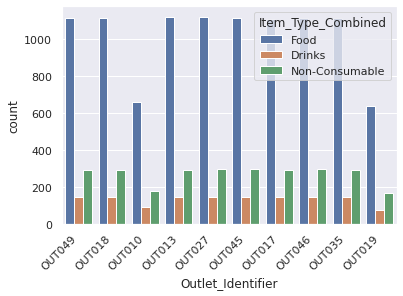

In [18]:
ax = sns.countplot(data=data, x='Outlet_Identifier', hue='Item_Type_Combined')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [19]:
#Create different price groups
def MRP_cat(x):
    if x <= 75:
        return 'Low'
    elif (x > 75) & (x <= 150):
        return 'Medium'
    elif (x > 150) & (x <= 200):
        return 'High'
    else:
        return 'Very High'

In [20]:
data['Item_MRP_Cat'] = data['Item_MRP']
data['Item_MRP_Cat'] = data['Item_MRP_Cat'].apply(MRP_cat)
data['Item_MRP_Cat'].value_counts()

data['Outlet_age'] = 2013 - data['Outlet_Establishment_Year']
data['item_info'] = data['Item_Type_Combined'] + data['Item_Type'] + data['Item_Fat_Content']
data['outlet_info'] = data['Outlet_Type'] + data['Outlet_Size'] + data['Outlet_Location_Type']
data['info']  = data['outlet_info'] + data['item_info'] + data['Item_MRP_Cat']

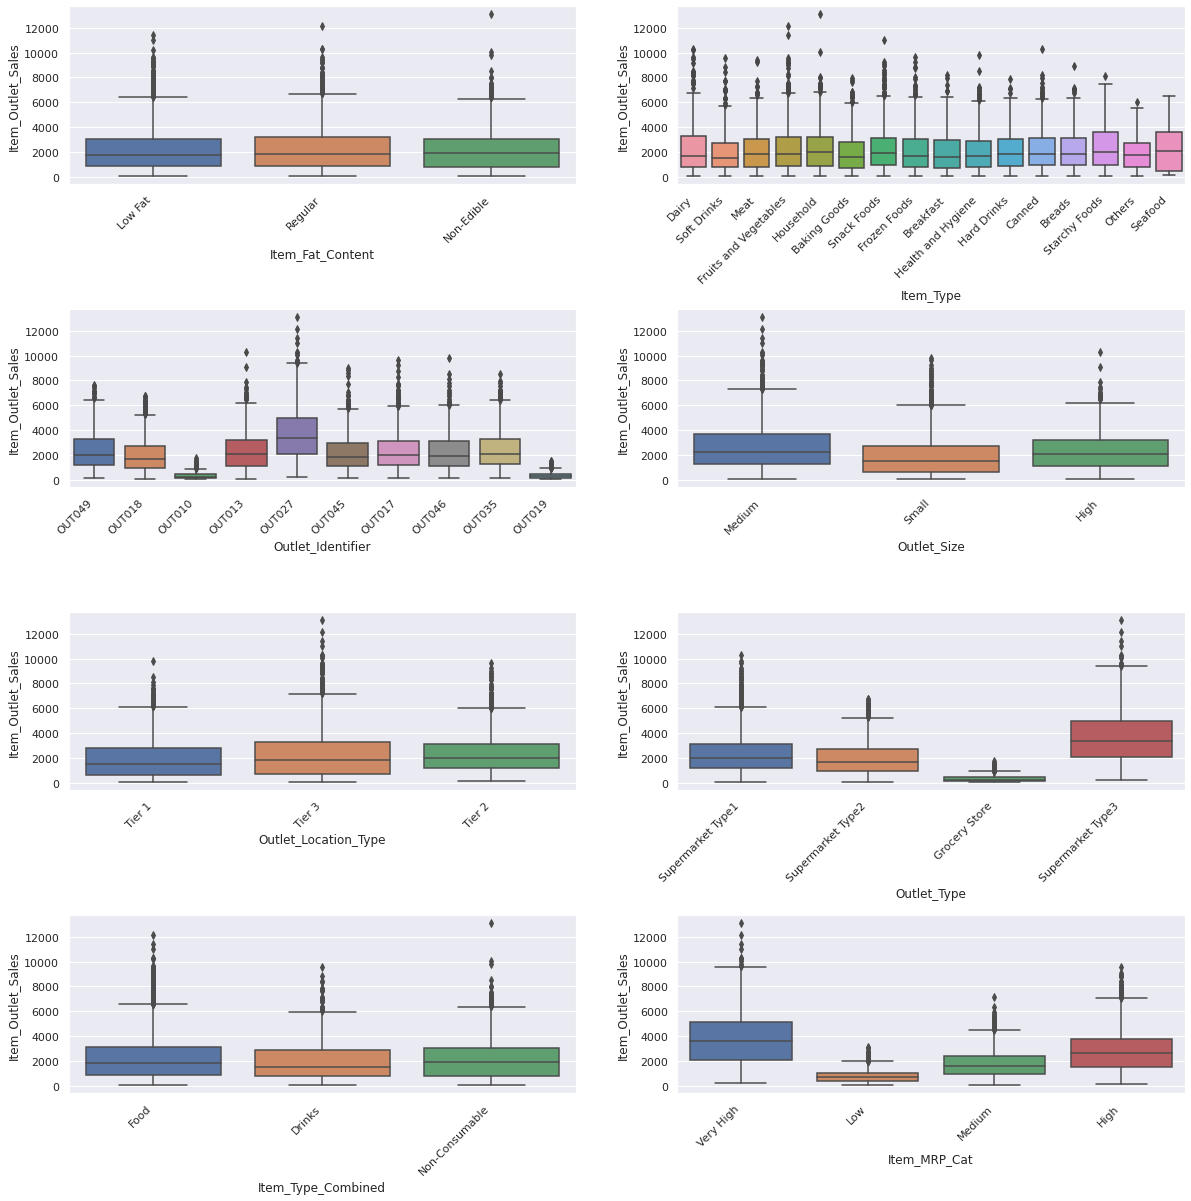

In [21]:
fig, axes = plt.subplots( nrows = 4, ncols = 2, figsize = (20,20))
fig.subplots_adjust(hspace = .7, wspace=.2)

for ax, i in zip(axes.ravel(), list(list(data.columns)[i] for i in [2,4,6,8,9,10,14,15])):
    sns.boxplot(x=i, y='Item_Outlet_Sales', data=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

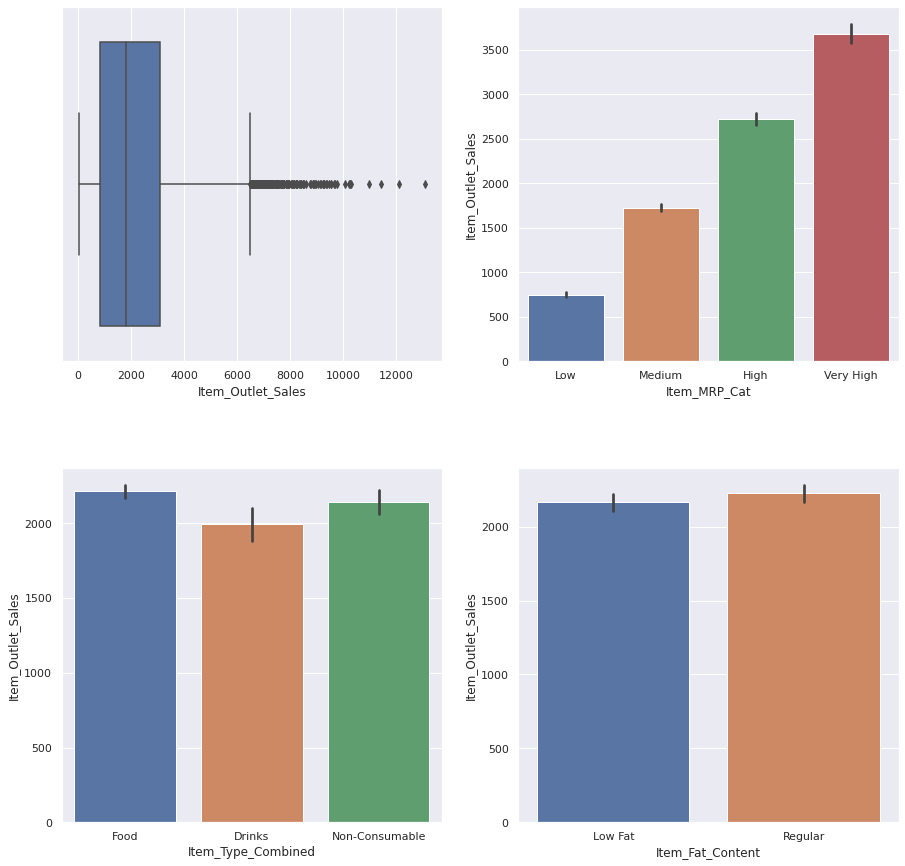

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
fig.subplots_adjust(hspace = .3, wspace=.2)
sns.boxplot(data['Item_Outlet_Sales'], ax=axs[0,0])
sns.barplot(data=data, x='Item_MRP_Cat', y='Item_Outlet_Sales', order=['Low', 'Medium', 'High', 'Very High'], ax=axs[0,1], )
sns.barplot(data=data, x='Item_Type_Combined', y='Item_Outlet_Sales', ax=axs[1,0])
sns.barplot(data= data[data['Item_Type_Combined']!= 'Non-Consumable'], x='Item_Fat_Content', y='Item_Outlet_Sales', ax=axs[1,1])

plt.show()

In [23]:
data.groupby(['Item_Type_Combined', 'Item_Fat_Content'])['Item_Fat_Content'].count()

Item_Type_Combined  Item_Fat_Content
Drinks              Low Fat             1208
                    Regular              109
Food                Low Fat             5291
                    Regular             4910
Non-Consumable      Non-Edible          2686
Name: Item_Fat_Content, dtype: int64

An item's weight doesn't influence sales 

An item's MRP is positively correlated with sales

There's no big difference in sales among the wider item categories, though edible items combined contribute more than non-consumables. 

Item fat content does influence sales.


**Encoding**

In [24]:
cols =['Outlet_Size', 'Outlet_Type', 'Outlet_Location_Type', 'Item_Outlet_Sales', 'Item_Visibility', 'Item_Type_Combined',
       'Item_Vis_MeanRatio', 'Item_Fat_Content', 'Item_Type', 'Item_Weight', 'Outlet_age',
       'source', 'Item_MRP', 'Item_MRP_Cat', 'item_info', 'outlet_info', 'info',] 
data3 = data[cols]

In [25]:
encoder=ce.OneHotEncoder(cols=['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Item_MRP_Cat', 'item_info', 'outlet_info', 'info', 'Item_Fat_Content', 'Item_Type',
                               'Item_Type_Combined'],
                         handle_unknown='return_nan',
                         return_df=True,use_cat_names=True)
data3 = encoder.fit_transform(data3)

# **Model**

**Train-test split**

In [26]:
#Divide into test and train:
train = data3.loc[data3['source']=='Train']
test = data3.loc[data3['source']=='Test']

test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

X = train.drop('Item_Outlet_Sales', axis=1)
Y = train['Item_Outlet_Sales']
test1 = test


X_train, X_test, Y_train, Y_test = train_test_split(X, np.log(Y), test_size = 0.2, random_state = 2021)

robust = RobustScaler()

robustX = robust.fit(X_train)
X_train = robustX.transform(X_train)
X_test = robustX.transform(X_test)
test1 = robustX.transform(test1)

**Feature selection**

In [27]:
RMSE_values = []

for feature in range(X_train.shape[1]):
    reg1 = DecisionTreeRegressor(criterion='mae')
    reg1.fit(pd.DataFrame(X_train)[feature].to_frame(), Y_train)
    y_scored = reg1.fit(pd.DataFrame(X_test)[feature].to_frame(), Y_test)
    RMSE_values.append(DecisionTreeRegressor.score(reg1, pd.DataFrame(X_test)[feature].to_frame(), Y_test))

In [28]:
RMSE_values = pd.Series(RMSE_values)
RMSE_values.index = X.columns

cols = list(RMSE_values.nlargest(20).index)
X_train, X_test, Y_train, Y_test = train_test_split(X[cols], np.log(Y), test_size = 0.3, random_state = 2021)
test1 = test[cols]

robustX = robust.fit(X_train)
X_train = robustX.transform(X_train)
X_test = robustX.transform(X_test)
test1 = robustX.transform(test1)

**Training and evaluation**

In [29]:
model_cat = CatBoostRegressor(learning_rate      = 0.1,
                              depth              = 5,
                              min_child_samples  = 50, 
                              n_estimators       = 100,
                              loss_function      = 'MAE', verbose=0, random_state=0)

model_cat.fit(X_train, Y_train) 
Y_predicted = model_cat.predict(X_test)

In [30]:
print('Mean squared error', '', mean_squared_error(np.exp(Y_test), np.exp(Y_predicted), squared = False))


Mean squared error  1098.1724016047394


In [31]:
print('Model score', (model_cat.score(X_test, Y_test)*100).round())

Model score 75.0
